# Pilot - Running Analysis

This Jupyter Notebook is to quickly test feasibility of the things I want to do with this project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import date
from butterworth_distance import get_distance, get_time
from scipy import stats
import seaborn as sns
sns.set()

In [2]:
running_df = pd.read_csv('GPSdata.csv', parse_dates=True, infer_datetime_format=True, encoding='utf-8')
running_df['datetime'] = pd.to_datetime(running_df['datetime']) # Redundancy to be 200% sure this works
# Timestamps are necessary to be able to do regressions
def to_timestamp(inputdatetime):
    return inputdatetime.timestamp()
running_df['timestamp'] = running_df['datetime'].apply(to_timestamp)


In [3]:
get_distance = np.vectorize(get_distance)
get_time = np.vectorize(get_time)
running_df['distance'] = get_distance(running_df['filename'])
running_df['duration'] = get_time(running_df['filename'])
running_df['avg_speed'] = running_df['distance'] / (running_df['duration']*60.0)

In [4]:
fiftypercentile = 19.0 #running_df['temperature'].quantile(q=0.5)
running_df['hot'] = running_df['temperature'] >= fiftypercentile
grouped = running_df.groupby('hot')
hotdays = grouped.get_group(True).reset_index(drop=True)
nothotdays = grouped.get_group(False).reset_index(drop=True)

In [8]:
normaltest1 = stats.normaltest(hotdays['avg_speed']).pvalue
normaltest2 = stats.normaltest(nothotdays['avg_speed']).pvalue
levene = stats.levene(hotdays['avg_speed'], nothotdays['avg_speed']).pvalue

print(normaltest1, normaltest2, levene)
stats.mannwhitneyu(hotdays['avg_speed'], nothotdays['avg_speed']).pvalue

0.331057835281 1 0.443881862003


/Users/vasundhara/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


0.1985505729131255

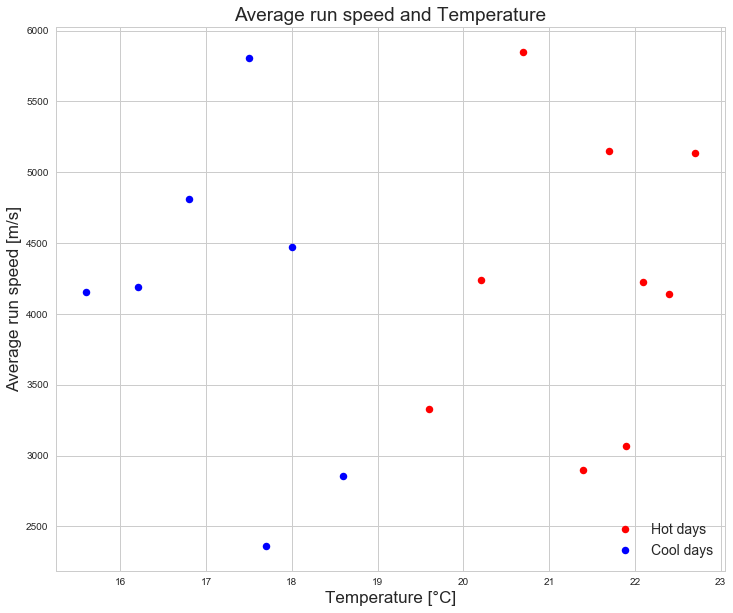

In [9]:
plt.figure(figsize=(12,10))
sns.set(style="whitegrid")
plt.plot(hotdays['temperature'], hotdays['distance'], 'r.', markersize=15, label='Hot days')
plt.plot(nothotdays['temperature'], nothotdays['distance'], 'b.', markersize=15, label='Cool days')
plt.xlabel('Temperature [°C]',fontsize=17)
plt.ylabel('Average run speed [m/s]',fontsize=17)
plt.title('Average run speed and Temperature',fontsize=19)
plt.legend(loc=4, fontsize=14)
plt.show()
#plt.savefig('distance_plot.png')

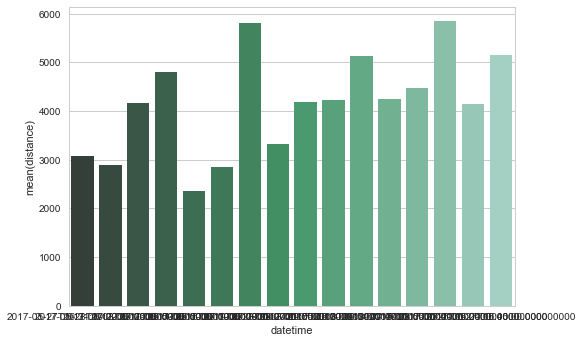

In [10]:
sns.barplot(running_df['datetime'], running_df['distance'], palette="BuGn_d")
plt.show()

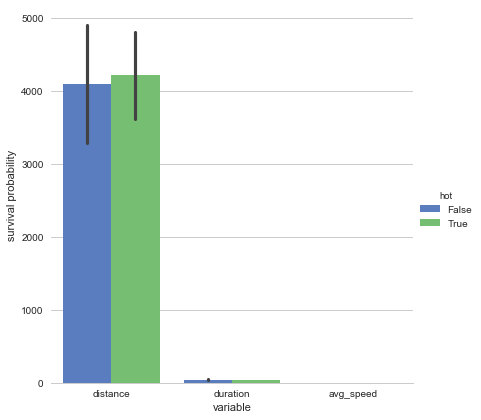

In [51]:
x = pd.melt(running_df, id_vars=['datetime', 'hot'], value_vars=['distance', 'duration', 'avg_speed'])
g = sns.factorplot(x="variable", y="value", hue="hot", data=x, size=6, kind="bar", palette=sns.color_palette('muted'))
g.despine(left=True)
g.set_ylabels("survival probability")
plt.show()

In [64]:
sns.set_palette(sns.color_palette('Blues_l'))
sns.factorplot(x="hot", y="distance", data=running_df, size=4, kind="bar")
sns.factorplot(x="hot", y="duration", data=running_df, size=4, kind="bar")
sns.factorplot(x="hot", y="avg_speed", data=running_df, size=4, kind="bar")
plt.show()

AttributeError: module 'matplotlib.cm' has no attribute 'Blues_l'

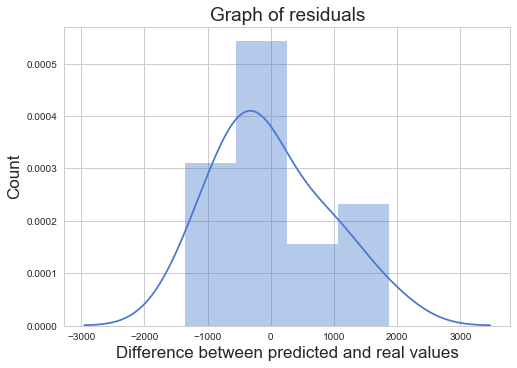

In [48]:
residuals = running_df['distance'] - running_df['predictions']
plt.figure()
sns.set_palette(sns.color_palette('muted'))
sns.distplot(residuals)
plt.xlabel('Difference between predicted and real values',fontsize=17)
plt.ylabel('Count',fontsize=17)
plt.title('Graph of residuals',fontsize=19)
plt.show()